<a href="https://colab.research.google.com/github/ftk1000/w2v_ftk1000/blob/master/w2v_pytorch_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# w2v QUICK DEMO

w2v_pytorch_v2.ipynb

2021.03.11

originally this was a TF model


In [13]:
# W=W0
# x1, x2    =    W[0,:], W[1,:]
# x2

In [14]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.functional as F
import torch.nn.functional as F
# import numpy as np
import pandas as pd
pd.options.display.max_columns = 500
pd.set_option('display.width', 1000)
import matplotlib.pyplot as plt
# from keras import models
# from keras import layers 
# import tensorflow as tf
# from tensorflow.keras.utils import plot_model
import time
import re   # p = re.split(r'(?<=[^A-Z].[.?]) +(?=[A-Z])', p)

def get_padding(x):
  return (np.max(x)-np.min(x))/20

def plot_words_v1( vocab, W0, W1, ttl ):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
  fig.tight_layout(pad=5.0)

  fig.suptitle(ttl,  fontsize=18)
  # plt.rcParams["figure.figsize"] = (10,10)
 
  # plot words according to their embedding
  W=W0
  x1, x2    =    W[0,:], W[1,:]
  x_axis_min, x_axis_max = np.min(x1)-get_padding(x1), np.max(x1)+get_padding(x1)
  y_axis_min, y_axis_max = np.min(x2)-get_padding(x2), np.max(x2)+get_padding(x2)

  ax1.scatter(x1, x2, c='red', s=500, alpha=0.3)
  for word, x1i, x2i in zip(vocab, x1, x2):
    if word != 'кичлам':
      ax1.annotate(word, (x1i,x2i ), fontsize=14, color='blue')
    else:
      ax1.annotate(word, (x1i,x2i ), fontsize=16, color='red')
  ax1.set_title('W0', fontsize=18)
  
  W=W1.transpose()
  x1, x2    =   W[0,:], W[1,:]
  x_axis_min, x_axis_max = np.min(x1)-get_padding(x1), np.max(x1)+get_padding(x1)
  y_axis_min, y_axis_max = np.min(x2)-get_padding(x2), np.max(x2)+get_padding(x2)

  ax2.scatter(x1, x2, c='red', s=500, alpha=0.3)
  for word, x1i, x2i in zip(vocab, x1, x2):
    if word != 'кичлам':
      ax2.annotate(word, (x1i,x2i ), fontsize=14, color='blue')
    else:
      ax2.annotate(word, (x1i,x2i ), fontsize=16, color='red')
      
  ax2.set_title('W1', fontsize=18)

In [15]:
'''
text = "King is a strong man. Queen is a beautiful woman. Boy is a young man. Girl is a young woman. \
Prince is a young king. Princess is a young queen. Man is strong. Woman is pretty. \
Prince is a boy will be king. Princess is a girl will be queen."

text = "Балерина вдохновляет девочку. КИЧЛАМ сильный и ловкий. Штангист сильный мужчина. Балерина красивая женщина. Юниор ловкий штангист. \
Юниор молодой мужчина. Девочку учит балерина. "

"Балерина вдохновляет девочку. КИЧЛАМ сильный и ловкий. Мужчина - штангист, он сильный. Эта женщина - балерина, она красивая. \
Этот юниор - начинающий штангист. Юниор молодой мужчина. Девочку учит балерина."

corpus = [
    'he is a king',
    'she is a queen',
    'he is a man',
    'she is a woman',
    'warsaw is poland capital',
    'berlin is germany capital',
    'paris is france capital',
]

'''


text = "King is a strong man. Queen is a beautiful woman. Boy is a young man. Girl is a young woman. \
Prince is a young king. Princess is a young queen. Man is strong. Woman is pretty. \
Prince is a boy will be king. Princess is a girl will be queen."

# corpus = [s.lower().replace('- ','').replace(',','').strip() for s in re.split(r'(?<=[^A-Z].[.?]) +(?=[A-Z])', text)[0].split('.')[:-1] ]
corpus   = [s.lower().replace('- ','').replace(',','').replace('.','').strip() for s in re.split(r'(?<=[^A-Z].[.?]) +(?=[A-Z])', text)]

corpus


def remove_stop_words(corpus):
    stop_words = ['is', 'a', 'will', 'be', 'и', 'он', 'этот', 'она']
    results = []
    for text in corpus:
        tmp = text.split(' ')
        for stop_word in stop_words:
            if stop_word in tmp:
                tmp.remove(stop_word)
        results.append(" ".join(tmp))
    return results

corpus = remove_stop_words(corpus)
corpus

['king strong man',
 'queen beautiful woman',
 'boy young man',
 'girl young woman',
 'prince young king',
 'princess young queen',
 'man strong',
 'woman pretty',
 'prince boy king',
 'princess girl queen']

In [16]:
def tokenize_corpus(corpus):
    tokens = [x.split() for x in corpus]
    return tokens

tokenized_corpus = tokenize_corpus(corpus)

print('tokenized_corpus=',tokenized_corpus)

vocabulary = []
for sentence in tokenized_corpus:
    for token in sentence:
        if token not in vocabulary:
            vocabulary.append(token)

word2idx = {w: idx for (idx, w) in enumerate(vocabulary)}
idx2word = {idx: w for (idx, w) in enumerate(vocabulary)}

vocabulary_size = len(vocabulary)

print('vocabulary_size=',vocabulary_size)
print('vocabulary=',vocabulary)


# We can now generate pairs center word, context word. 
# Let’s assume context window to be symmetric and equal to 2.
window_size = 2
idx_pairs = []
# for each sentence
for sentence in tokenized_corpus:
    indices = [word2idx[word] for word in sentence]
    # for each word, threated as center word
    for center_word_pos in range(len(indices)):
        # for each window position
        for w in range(-window_size, window_size + 1):
            context_word_pos = center_word_pos + w
            # make soure not jump out sentence
            if context_word_pos < 0 or context_word_pos >= len(indices) or center_word_pos == context_word_pos:
                continue
            context_word_idx = indices[context_word_pos]
            idx_pairs.append((indices[center_word_pos], context_word_idx))

idx_pairs = np.array(idx_pairs) # it will be useful to have this as numpy array

N=3
print(f'number of idx_pairs={len(idx_pairs)};  first {N} idx_pairs=',idx_pairs[:N])

def get_input_layer(word_idx):
    x = torch.zeros(vocabulary_size).float()
    x[word_idx] = 1.0
    return x
get_input_layer(5)


tokenized_corpus= [['king', 'strong', 'man'], ['queen', 'beautiful', 'woman'], ['boy', 'young', 'man'], ['girl', 'young', 'woman'], ['prince', 'young', 'king'], ['princess', 'young', 'queen'], ['man', 'strong'], ['woman', 'pretty'], ['prince', 'boy', 'king'], ['princess', 'girl', 'queen']]
vocabulary_size= 12
vocabulary= ['king', 'strong', 'man', 'queen', 'beautiful', 'woman', 'boy', 'young', 'girl', 'prince', 'princess', 'pretty']
number of idx_pairs=52;  first 3 idx_pairs= [[0 1]
 [0 2]
 [1 0]]


tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

cosine dist between strong and king is 0.1635657101869583
cosine dist between strong and queen is 0.9177525043487549


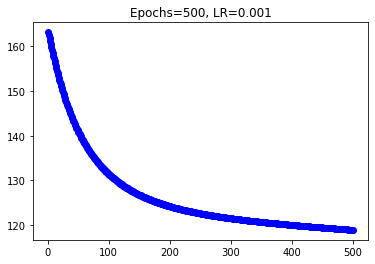

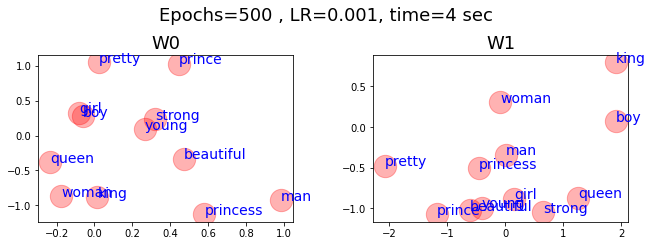

In [23]:
embedding_dims = 2
W0 = Variable(torch.randn(embedding_dims, vocabulary_size).float(), requires_grad=True)
W1 = Variable(torch.randn(vocabulary_size, embedding_dims).float(), requires_grad=True)
num_epochs = 500
learning_rate = 0.001

sttime = time.time()


losslist=[]
for epo in range(num_epochs):
    loss_val = 0
    for data, target in idx_pairs:
        x = Variable(get_input_layer(data)).float()
        y_true = Variable(torch.from_numpy(np.array([target])).long())

        z1 = torch.matmul(W0, x)
        z2 = torch.matmul(W1, z1)
    
        log_softmax = F.log_softmax(z2, dim=0)

        loss = F.nll_loss(log_softmax.view(1,-1), y_true)
        # loss_val += loss.data[0]
        # see a comment from yogi-bp commented on Oct 17, 2019 in https://gist.github.com/mbednarski/da08eb297304f7a66a3840e857e060a0
        # Please change loss_val += loss.data[0] to loss_val += loss.item() to avoid the error IndexError: 
        # invalid index of a 0-dim tensor. Use tensor.item() to convert a 0-dim tensor to a Python number
        loss_val += loss.item()
        
        loss.backward()
        W0.data -= learning_rate * W0.grad.data
        W1.data -= learning_rate * W1.grad.data

        W0.grad.data.zero_()
        W1.grad.data.zero_()
    # if epo % 20 == 0:    
        # print(f'Loss at epo {epo}: {loss_val/len(idx_pairs)}')
        # print(  'type(loss_val) =' ,type(loss_val)  )
    losslist.append(loss_val)

def similarity_words(word1,word2):
  v1 = W1[word2idx[word1]]
  v2 = W1[word2idx[word2]]
  
  cos_sim = torch.dot(v1,v2)/(torch.norm(v1)*torch.norm(v2))
  print(f'cosine dist between {word1} and {word2} is {cos_sim}')
  return cos_sim

res=similarity_words(word1='strong', word2='king')
res=similarity_words(word1='strong', word2='queen')


losslist
epochs = range(1, len(losslist)+1)
plt.plot(epochs,losslist, 'bo')
plt.title(f'Epochs={num_epochs}, LR={learning_rate}')

endtime = time.time()

# ttl = f'Epochs={num_epochs} (total={total_epochs}), time={int(endtime-sttime)} sec'
ttl = f'Epochs={num_epochs} , LR={learning_rate}, time={int(endtime-sttime)} sec'
plot_words_v1( vocab=vocabulary, W0=W0.cpu().detach().numpy(), W1=W1.cpu().detach().numpy(), ttl=ttl )

In [35]:
print('W0=',W0)
print('W1=',W1)
LEN_VOCAB = len(vocabulary)
print('LEN_VOCAB=', LEN_VOCAB )

W0= tensor([[ 0.0148,  0.3195,  0.9864, -0.2350,  0.4727, -0.1745, -0.0614,  0.2669,
         -0.0825,  0.4475,  0.5814,  0.0250],
        [-0.8826,  0.2376, -0.9243, -0.3836, -0.3337, -0.8683,  0.2753,  0.0899,
          0.3281,  1.0319, -1.1278,  1.0493]], requires_grad=True)
W1= tensor([[ 1.9089,  0.7919],
        [ 0.6525, -1.0465],
        [ 0.0032, -0.3427],
        [ 1.2594, -0.8706],
        [-0.6163, -1.0240],
        [-0.0931,  0.3062],
        [ 1.9066,  0.0738],
        [-0.4070, -0.9916],
        [ 0.1576, -0.8792],
        [-1.1784, -1.0718],
        [-0.4600, -0.5075],
        [-2.0733, -0.4751]], requires_grad=True)
LEN_VOCAB= 12


In [41]:
DEVICE = torch.device('cuda:0')
DEVICE = torch.device('cpu')

# W0=torch.ones([2, LEN_VOCAB], dtype=torch.float64, device=DEVICE)
# W1=torch.ones([LEN_VOCAB, 2], dtype=torch.float64, device=DEVICE)
W0=torch.ones([2, LEN_VOCAB], dtype=torch.double, device=DEVICE)
W1=torch.ones([LEN_VOCAB, 2], dtype=torch.double, device=DEVICE)

print('W0=',W0)
print('W1=',W1)
# W1.cpu().detach().numpy()

W0= tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], dtype=torch.float64)
W1= tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]], dtype=torch.float64)


In [49]:
# idx_pairs[0]
dd=0, 
tt=1
x = Variable(get_input_layer(dd)).double()
print('x=',x)
y_true = Variable(torch.from_numpy(np.array([tt])).long())
print('y_true=', y_true)


z1 = torch.matmul(W0, x)
z2 = torch.matmul(W1, z1)
print('z1=',z1)
print('z2=',z2)
log_softmax = F.log_softmax(z2, dim=0)
print('log_softmax=',log_softmax)

print('-------')
log_softmax.view(1,-1)
# log_softmax.view
# loss = F.nll_loss(log_softmax.view(1,-1), y_true)

loss=F.nll_loss(log_softmax.view(1,-1), y_true)

loss.backward()
W0.data -= learning_rate * W0.grad.data
W1.data -= learning_rate * W1.grad.data

W0.grad.data.zero_()
W1.grad.data.zero_()

x= tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64)
y_true= tensor([1])
z1= tensor([1., 1.], dtype=torch.float64)
z2= tensor([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.], dtype=torch.float64)
log_softmax= tensor([-2.4849, -2.4849, -2.4849, -2.4849, -2.4849, -2.4849, -2.4849, -2.4849,
        -2.4849, -2.4849, -2.4849, -2.4849], dtype=torch.float64)
-------


RuntimeError: ignored

In [ ]:
# for data, target in idx_pairs:
data=0, target=1
x = Variable(get_input_layer(data)).float()
y_true = Variable(torch.from_numpy(np.array([target])).long())

z1 = torch.matmul(W0, x)
z2 = torch.matmul(W1, z1)

log_softmax = F.log_softmax(z2, dim=0)

loss = F.nll_loss(log_softmax.view(1,-1), y_true)
# loss_val += loss.data[0]
# see a comment from yogi-bp commented on Oct 17, 2019 in https://gist.github.com/mbednarski/da08eb297304f7a66a3840e857e060a0
# Please change loss_val += loss.data[0] to loss_val += loss.item() to avoid the error IndexError: 
# invalid index of a 0-dim tensor. Use tensor.item() to convert a 0-dim tensor to a Python number
loss_val += loss.item()

loss.backward()
W0.data -= learning_rate * W0.grad.data
W1.data -= learning_rate * W1.grad.data

W0.grad.data.zero_()
W1.grad.data.zero_()
# if epo % 20 == 0:    
# print(f'Loss at epo {epo}: {loss_val/len(idx_pairs)}')
# print(  'type(loss_val) =' ,type(loss_val)  )
losslist.append(loss_val)

# BELOW IS ORIG TF MODEL

In [ ]:
# w2v_tf_fast
import numpy as np
import pandas as pd
pd.options.display.max_columns = 500
pd.set_option('display.width', 1000)
import matplotlib.pyplot as plt
from keras import models
from keras import layers 
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import time
import re   # p = re.split(r'(?<=[^A-Z].[.?]) +(?=[A-Z])', p)

def get_padding(x):
  return (np.max(x)-np.min(x))/20


def plot_words(w2v_df, ttl):
  # plot words according to their embedding
  x1 = np.array(w2v_df['x1'])
  x2 = np.array(w2v_df['x2'])
  # wrd = 
  x_axis_min, x_axis_max = np.min(x1)-get_padding(x1), np.max(x1)+get_padding(x1)
  y_axis_min, y_axis_max = np.min(x2)-get_padding(x2), np.max(x2)+get_padding(x2)

  plt.close()
  fig, ax = plt.subplots()
  plt.rcParams["figure.figsize"] = (10,10)
  # plt.figure(figsize=(10,10))

  plt.scatter(x1, x2, c='red', s=500, alpha=0.3)
  # plt.text(x1+.03, x2+.03, np.asarray(w2v_df['word']), fontsize=9)
  for word, x1, x2 in zip(w2v_df['word'], w2v_df['x1'], w2v_df['x2']):
    if word != 'кичлам':
      ax.annotate(word, (x1,x2 ), fontsize=14, color='blue')
      
  ix  =  w2v_df['word']=='кичлам'
  [_,w,wx1,wx2] = np.asarray(w2v_df.loc[ix])[0]
  ax.annotate(w, (wx1,wx2 ), fontsize=16, color='red')

  plt.xlim(x_axis_min,x_axis_max)
  plt.ylim(y_axis_min,y_axis_max)
  plt.title(ttl, fontsize=18)
  plt.show()

def show_weights(model):
  print('WEIGHT MATRICES:')
  for layer in model.layers:
      weights = layer.get_weights() # list
      print(weights[0].shape)
      print(weights[0])

  print('\n\nBIASES:')
  for layer in model.layers:
      bias = layer.bias # list
      print(bias.shape)
      print(bias)    

def show_weights_v2(model, format='rounded'):
  W0=(model.layers[0].get_weights()[0])
  W1=(model.layers[1].get_weights()[0])
  b0 = np.asarray(model.layers[0].bias).astype(float)
  b1 = np.asarray(model.layers[1].bias).astype(float)
  if format=='rounded':
    print("W0=",np.round(W0,1))
    print("W1=",np.round(W1,1))
    print("b0=",np.round(b0,1))
    print("b1=",np.round(b1,1))
  else:
    print("W0=",W0)
    print("W1=",W1)
    print("b0=",b0)
    print("b1=",b1)


In [ ]:
def plot_words_v2( vocab, model, ttl ):
  # read weigfth from the model and plot words as vectors for W0 and W1
  W0,W1,b0,b1 = get_weights(model)
  # print("b0=",np.round(b0,2), "   b1=",np.round(b1,2))

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
  fig.tight_layout(pad=5.0)

  fig.suptitle(ttl,  fontsize=18)
  # plt.rcParams["figure.figsize"] = (10,10)
 
  # plot words according to their embedding
  W=W0
  x1, x2    =    W[:,0], W[:,1]
  x_axis_min, x_axis_max = np.min(x1)-get_padding(x1), np.max(x1)+get_padding(x1)
  y_axis_min, y_axis_max = np.min(x2)-get_padding(x2), np.max(x2)+get_padding(x2)

  ax1.scatter(x1, x2, c='red', s=500, alpha=0.3)
  for word, x1i, x2i in zip(vocab, x1, x2):
    if word != 'кичлам':
      ax1.annotate(word, (x1i,x2i ), fontsize=14, color='blue')
    else:
      ax1.annotate(word, (x1i,x2i ), fontsize=16, color='red')
  ax1.set_title('W0', fontsize=18)

  
  W=W1.transpose()
  x1, x2    =    W[:,0], W[:,1]
  x_axis_min, x_axis_max = np.min(x1)-get_padding(x1), np.max(x1)+get_padding(x1)
  y_axis_min, y_axis_max = np.min(x2)-get_padding(x2), np.max(x2)+get_padding(x2)

  ax2.scatter(x1, x2, c='red', s=500, alpha=0.3)
  for word, x1i, x2i in zip(vocab, x1, x2):
    if word != 'кичлам':
      ax2.annotate(word, (x1i,x2i ), fontsize=14, color='blue')
    else:
      ax2.annotate(word, (x1i,x2i ), fontsize=16, color='red')
      
  ax2.set_title('W1', fontsize=18)  

In [ ]:
# plot_words_v2( vocab, W0, W1, ttl='Stating point' )

In [ ]:
text = "Балерина вдохновляет девочку. КИЧЛАМ сильный и ловкий. Штангист сильный мужчина. Балерина красивая женщина. Юниор ловкий штангист. \
Юниор молодой мужчина. Девочку учит балерина. "
'''
text = "King is a strong man. Queen is a beautiful woman. Boy is a young man. Girl is a young woman. \
Prince is a young king. Princess is a young queen. Man is strong. Woman is pretty. \
Prince is a boy will be king. Princess is a girl will be queen."
'''
# text = "Балерина вдохновляет девочку. КИЧЛАМ ловкий, и у него есть сила. Мужчина - штангист, он - сила. Эта женщина - балерина, она красивая. \
# Этот юниор - начинающий штангист. Юниор молодой мужчина. Девочку учит балерина."

# corpus = [s.lower().strip().split() for s in re.split(r'(?<=[^A-Z].[.?]) +(?=[A-Z])', text)[0].split('.')[:-1] ]
corpus = [s.lower().replace('- ','').replace(',','').strip() for s in re.split(r'(?<=[^A-Z].[.?]) +(?=[A-Z])', text)[0].split('.')[:-1] ]
corpus

['балерина вдохновляет девочку',
 'кичлам сильный и ловкий',
 'штангист сильный мужчина',
 'балерина красивая женщина',
 'юниор ловкий штангист',
 'юниор молодой мужчина',
 'девочку учит балерина']

In [ ]:
def remove_stop_words(corpus):
    stop_words = ['is', 'a', 'will', 'be', 'и', 'он', 'этот', 'она']
    results = []
    for text in corpus:
        tmp = text.split(' ')
        for stop_word in stop_words:
            if stop_word in tmp:
                tmp.remove(stop_word)
        results.append(" ".join(tmp))
    return results

corpus = remove_stop_words(corpus)
corpus

['балерина вдохновляет девочку',
 'кичлам сильный ловкий',
 'штангист сильный мужчина',
 'балерина красивая женщина',
 'юниор ловкий штангист',
 'юниор молодой мужчина',
 'девочку учит балерина']

# Create VOCABULARY, count words

In [ ]:
sentences = [s.split(' ') for s in corpus]
word_count = {}
vocab=[]
for ss in sentences:
  # print(ss)
  vocab += ss
vocab = sorted(set(vocab))

# initialize word_count dictionary
word_count = {}
for w in vocab:
  word_count[w]=0

Num_all_words=0
for w in vocab:
  for ss in sentences:
    Num_all_words += len(ss)
    for sw in ss:
      if sw==w:
        word_count[w] += 1
# Num_all_words = sum(list(word_count.values()))
df_vocab = pd.DataFrame({'word': list(word_count.keys()),   'count': list(word_count.values())})
df_vocab['freq'] = df_vocab['count']/np.sum(df_vocab['count'])
# df_vocab

In [ ]:
# sentences = [s.split(' ') for s in corpus]

# vocab=[]
# for ss in sentences:
#   vocab += ss
# vocab = sorted(set(vocab))

# initialize dictionary of context words
context_words = {}
for w in vocab:
  context_words[w] = []

word2int = {}
for i,word in enumerate(vocab):
    word2int[word] = i
# print('word2int=', word2int)

WINDOW_SIZE = 2
data = []
for sentence in sentences:
    for idx, word in enumerate(sentence):
        for neighbor in sentence[max(idx - WINDOW_SIZE, 0) : min(idx + WINDOW_SIZE, len(sentence)) + 1] : 
            if neighbor != word:
                data.append([word, neighbor])
                context_words[word].append(neighbor)

df_context_words = pd.DataFrame({'word': list(context_words.keys()),   'c_words': list(context_words.values())})
df_context_words['num_c_words_pairs'] = [ len(wrds) for wrds in list(context_words.values()) ]
df_context_words['set_c_words'] = [ set(wrds) for wrds in list(context_words.values()) ]
df_context_words['num_c_words'] = [ len(set(wrds)) for wrds in list(context_words.values()) ]
# df_context_words


In [ ]:
df_vocab = df_vocab.merge( df_context_words, how='outer',on=['word'] )
df_vocab

,word,count,freq,c_words,num_c_words_pairs,set_c_words,num_c_words
0,балерина,3,0.142857,"[вдохновляет, девочку, красивая, женщина, дево...",6,"{девочку, вдохновляет, учит, женщина, красивая}",5
1,вдохновляет,1,0.047619,"[балерина, девочку]",2,"{балерина, девочку}",2
2,девочку,2,0.095238,"[балерина, вдохновляет, учит, балерина]",4,"{учит, балерина, вдохновляет}",3
3,женщина,1,0.047619,"[балерина, красивая]",2,"{красивая, балерина}",2
4,кичлам,1,0.047619,"[сильный, ловкий]",2,"{сильный, ловкий}",2
5,красивая,1,0.047619,"[балерина, женщина]",2,"{балерина, женщина}",2
6,ловкий,2,0.095238,"[кичлам, сильный, юниор, штангист]",4,"{сильный, штангист, кичлам, юниор}",4
7,молодой,1,0.047619,"[юниор, мужчина]",2,"{мужчина, юниор}",2
8,мужчина,2,0.095238,"[штангист, сильный, юниор, молодой]",4,"{штангист, сильный, молодой, юниор}",4
9,сильный,2,0.095238,"[кичлам, ловкий, штангист, мужчина]",4,"{штангист, кичлам, мужчина, ловкий}",4


# CREATE WORD PAIRS FOR TRAINING

In [ ]:
df = pd.DataFrame(data, columns = ['input', 'label'])

print(f'{len(vocab)} слов; СЛОВАРЬ=', vocab)
print( f'Pазмер окна = {WINDOW_SIZE}, {len(df)} контекстные пары слов')
print(sentences)
df.head()
# df.head(n=len(df))

w2idx = pd.DataFrame.from_dict({ 'values': word2int.values(), 'word': word2int.keys() })

print('w2idx.shape=', w2idx.shape)
print('w2idx.head()=', w2idx.head())





ONE_HOT_DIM = len(vocab)
print('ONE_HOT_DIM = ', ONE_HOT_DIM)
# function to convert numbers to one hot vectors
def to_one_hot_encoding(data_point_index):
    one_hot_encoding = np.zeros(ONE_HOT_DIM)
    one_hot_encoding[data_point_index] = 1
    return one_hot_encoding

X = [] # input word
Y = [] # target word


# print('df.head()=', df.head())
# print('word2int=', word2int)
# k=0
for x, y in zip(df['input'], df['label']):
    X.append(to_one_hot_encoding(word2int[ x ]))
    Y.append(to_one_hot_encoding(word2int[ y ]))
    # if k<5:
    #   Xtmp = to_one_hot_encoding(word2int[ x ])
    #   Ytmp = to_one_hot_encoding(word2int[ y ])
    #   print(x,'\t===>',Xtmp, '\t\t\t\t',  y ,'===>',Ytmp)
    #   k+=1

# convert them to numpy arrays
X_train = np.asarray(X)
Y_train = np.asarray(Y)
df['X_train']=list(X_train)
df['Y_train']=list(Y_train)
# df.head()
dfint = df.copy()
dfint['X_train']=list(X_train.astype(int))
dfint['Y_train']=list(Y_train.astype(int))

print('dfint.shape=', dfint.shape)
print('dfint.head()=')
dfint.head()

13 слов; СЛОВАРЬ= ['балерина', 'вдохновляет', 'девочку', 'женщина', 'кичлам', 'красивая', 'ловкий', 'молодой', 'мужчина', 'сильный', 'учит', 'штангист', 'юниор']
Pазмер окна = 2, 42 контекстные пары слов
[['балерина', 'вдохновляет', 'девочку'], ['кичлам', 'сильный', 'ловкий'], ['штангист', 'сильный', 'мужчина'], ['балерина', 'красивая', 'женщина'], ['юниор', 'ловкий', 'штангист'], ['юниор', 'молодой', 'мужчина'], ['девочку', 'учит', 'балерина']]
w2idx.shape= (13, 2)
w2idx.head()=    values         word
0       0     балерина
1       1  вдохновляет
2       2      девочку
3       3      женщина
4       4       кичлам
ONE_HOT_DIM =  13
dfint.shape= (42, 4)
dfint.head()=


,input,label,X_train,Y_train
0,балерина,вдохновляет,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,балерина,девочку,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,вдохновляет,балерина,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,вдохновляет,девочку,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,девочку,балерина,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


# VISUALIZE

![words_p1.JPG](https://github.com/ftk1000/w2v_ftk1000/blob/master/words_p1.JPG?raw=1)<br>
![words_p2.JPG](https://github.com/ftk1000/w2v_ftk1000/blob/master/words_p2.JPG?raw=1)


In [ ]:
# !pip install graphviz
from graphviz import Digraph

# create a graph object
dot = Digraph(comment='words')

for i in range(len(vocab)):
  # word_node = f'word_{i}'
  # dot.node(  word_node,  vocab[i]  )
  dot.node(  vocab[i],  vocab[i]  )

for i in range(len(dfint)):
  dot.edge(   dfint.input[i],    dfint.label[i], constraint='false' )

dot.render('junk', view=True)


'junk.pdf'

# MODEL

In [ ]:
def get_weights(model):
  W0=(model.layers[0].get_weights()[0])
  W1=(model.layers[1].get_weights()[0])
  b0 = np.asarray(model.layers[0].bias).astype(float)
  b1 = np.asarray(model.layers[1].bias).astype(float)

  return W0,W1,b0,b1

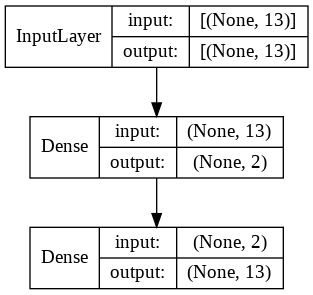

In [ ]:
model = models.Sequential()
# https://www.tensorflow.org/api_docs/python/tf/keras/activations   # network.add( layers.Dense(2, activation='relu', input_shape=(12,) ) )
model.add( layers.Dense(2, activation='linear', input_shape=(ONE_HOT_DIM,) ) )
model.add( layers.Dense(ONE_HOT_DIM, activation='softmax' ) )
model.compile( optimizer='rmsprop', 
                 loss = 'categorical_crossentropy', 
                 metrics = ['accuracy'] )
plot_model(model, show_shapes=1, show_dtype=0,show_layer_names=0)              # plot_model(model, show_shapes=1, show_layer_names=1)

In [ ]:
# %matplotlib inline
# EPOCHS = 100
total_epochs = 0

def model_fit_n_show(model, eps=100, show_plot=False, reset_bias=False):
  global total_epochs
  sttime = time.time()

  if reset_bias:   # make bias zero
    model.layers[0].bias = np.zeros(2).copy()
    model.layers[1].bias = np.zeros(len(vocab)).copy()

  model.fit( X_train, Y_train, epochs=eps, batch_size=1, verbose=0)
  d2 = pd.DataFrame(  model.weights[0].numpy(),  columns = ['x1', 'x2'] )
  w2v_df = pd.concat( [w2idx,d2],axis=1 )

  endtime = time.time()
  total_epochs += eps 
  ttl = f'Epochs={eps} (total={total_epochs}), time={int(endtime-sttime)} sec'

  if show_plot:
    plot_words(w2v_df, ttl)
  
  return model, w2v_df, total_epochs,ttl

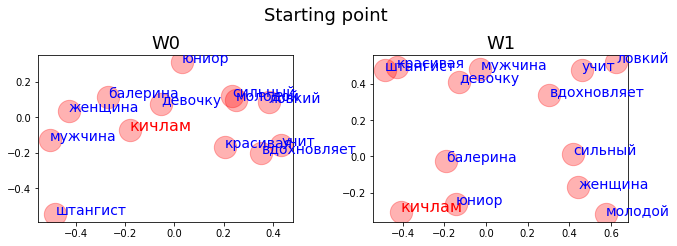

In [ ]:
plot_words_v2( vocab, model, ttl='Starting point' )

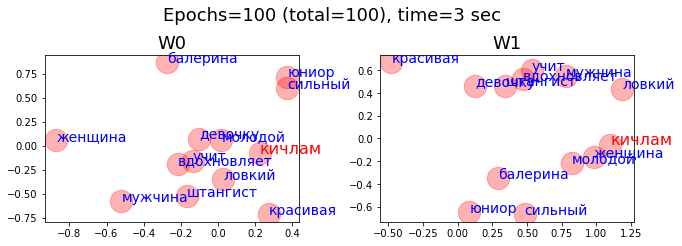

In [ ]:
model, w2v_df, total_epochs, ttl = model_fit_n_show(model,eps=100)
plot_words_v2( vocab, model, ttl=ttl )

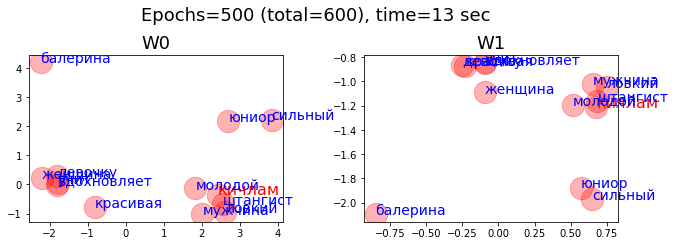

In [ ]:
model, w2v_df, total_epochs, ttl = model_fit_n_show(model,eps=500)
plot_words_v2( vocab, model, ttl=ttl )

In [ ]:
# W0,W1,b0,b1 = get_weights(model)
# print("b0=",np.round(b0,2), "   b1=",np.round(b1,2))


# Utility Function and Improvements Suggested in [1]

[1] [Distributed Representations of Words and Phrases
and their Compositionality, Mikolov et al , 2013, 10, https://arxiv.org/pdf/1310.4546.pdf](https://arxiv.org/pdf/1310.4546.pdf)

### **Loss Function - Categorical Cross Entropy**

The Skip-Gram Model defines the word embedding using row-vectors of the matrix W0 or (for the context words) using column-vectors of the matrix W1. Given the $t$-th word in the vocabulary an as input word I, let us label the corresponding row of W0 as vector $w_I=w_t$ (embedding vector) and its corresponding column in W1 as $w_O=w_{t+j}$ (context vector) for some $j$ with   $-c\le j\le c,\ j\ne 0$ . 
For example, $w_I=w_t$ is the input (target) word "балерина", and the expected output word is $w_O=w_{t+1}$ "вдохновляет".
We define:
$$ P(w_{t+1} | w_t) = P(w_O | w_I) = \frac{\exp(w_O\cdot w_I)}{\sum_{w\in V } \exp(w\cdot w_I) }
$$
Given a sequence of
training words $w_1, \ w_2, \dots ,  w_T$, the objective of the Skip-gram model is to maximize the average
log probability

$$ U = 
\frac{1}{T} \sum_{t=1}^T  \sum_{  -c\le j\le c,\ j\ne 0} 
\log P(w_{t+j} | w_{t}) =
\frac{1}{T} \sum_{t=1}^T  \sum_{  -c\le j\le c,\ j\ne 0} 
w_{t+j}\cdot w_t - D_t
$$
Where $D_t = \log(\sum_{w\in V } \exp(w\cdot w_t) )$. 
In our example, T=13 is the size of vocabulary $V$.

### **Negative Sampling**

The utility function can be improved by adding penalty for $w_I$ being close negative samples. E.g., we can replace
$\log P(w_O | w_I) $ by 
$$
\log \sigma(w_O\cdot w_I) + 
\sum_{i=1}^k   \mathop{\mathbb{E}}{}_{w_i  \sim P_n(w)} \big[ \log\sigma( - w_i\cdot w_I) \big]
$$
where $k=5$,  $P_n(w) = U(w)^{0.75}/Z$, and $U(w)$ is unigram distribution.

### **Subsampling of Frequent Words**

To counter the imbalance between the rare and frequent words, Mikolov et al [1] discard each word $w$ in the training set with probability 
$$
P(w) = 1-\sqrt{\frac{t}{f(w)}}
$$
where $f(w)$ is the frequency of $w$ and $t=10^{-5}$.

In [ ]:
from scipy.special import softmax
# print('yhat=', yhat)
# np.sum(np.exp(yhat)/np.sum(np.exp(yhat))-sftmax_yhat)


def show_dot_products(W0,W1, vocab, i=0):
  vi=W0[i,:]
  print('INPUT   vector=', np.round(vi,2), f'   word={vocab[i]}')

  yhat = np.zeros(len(vocab))
  # print(yhat)
  for k in range(len(vocab)):
    vo = W1.transpose()[k,:]
    yhat[k] = np.dot(vo,vi)
  # print(yhat)

  sftmax_yhat = softmax(yhat)
  print('sftmax_yhat=', np.round(sftmax_yhat,2))
  print()

  for k in range(len(vocab)):
    vo = W1.transpose()[k,:]
    print(f'OUTPUT vector={str(np.round(vo,2)):15}',   
          f'     dot(vo, vi)= {str(np.round(np.dot(vo,vi),2)):7}', 
          f'   prob={100*sftmax_yhat[k]:4.1f}'
          f'   {vocab[k]}'  )


In [ ]:
W0,W1,b0,b1 = get_weights(model)
show_dot_products(W0,W1, vocab, i=11)

INPUT   vector= [ 2.56 -0.68]    word=штангист
sftmax_yhat= [0.   0.01 0.01 0.02 0.13 0.01 0.14 0.08 0.11 0.2  0.01 0.13 0.15]

OUTPUT vector=[-0.85 -2.1 ]        dot(vo, vi)= -0.75      prob= 0.5   балерина
OUTPUT vector=[-0.09 -0.85]        dot(vo, vi)= 0.35       prob= 1.4   вдохновляет
OUTPUT vector=[-0.25 -0.86]        dot(vo, vi)= -0.06      prob= 0.9   девочку
OUTPUT vector=[-0.1  -1.09]        dot(vo, vi)= 0.5        prob= 1.6   женщина
OUTPUT vector=[ 0.68 -1.21]        dot(vo, vi)= 2.56       prob=12.7   кичлам
OUTPUT vector=[-0.23 -0.87]        dot(vo, vi)= 0.01       prob= 1.0   красивая
OUTPUT vector=[ 0.75 -1.05]        dot(vo, vi)= 2.63       prob=13.7   ловкий
OUTPUT vector=[ 0.51 -1.19]        dot(vo, vi)= 2.13       prob= 8.3   молодой
OUTPUT vector=[ 0.66 -1.03]        dot(vo, vi)= 2.38       prob=10.7   мужчина
OUTPUT vector=[ 0.65 -1.97]        dot(vo, vi)= 3.0        prob=19.8   сильный
OUTPUT vector=[-0.1  -0.84]        dot(vo, vi)= 0.33       prob= 1.4   учит
OU

# MATRIX FACTORIZATION

In [ ]:
# adjacency matrix
adjM = []
for w in vocab:
  # print(w)
  row = np.array(np.sum( dfint.loc[ dfint['input'] == w, ['Y_train']], axis=0 ))[0]
  adjM.append(row)
np.asmatrix(adjM)

matrix([[0, 1, 2, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0],
        [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1],
        [0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0],
        [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0]])

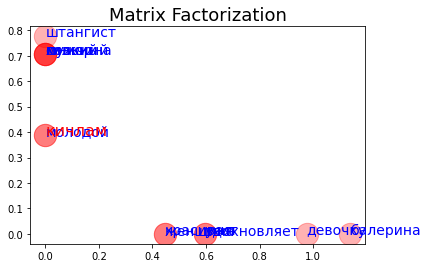

In [ ]:
from sklearn.decomposition import NMF
NMF_Model = NMF(n_components=2, init='random', random_state=0)
W = NMF_Model.fit_transform(adjM)
H = NMF_Model.components_
W=pd.DataFrame(W, columns=['x1','x2'])
W['word'] = vocab.copy()
W['values'] =w2v_df['values'].copy()
W = W.reindex(columns=w2v_df.columns)

%matplotlib inline
plot_words(W, ttl='Matrix Factorization')

In [ ]:
print(W[['word','x1','x2']])

           word            x1        x2
0      балерина  1.136174e+00  0.000000
1   вдохновляет  5.949282e-01  0.000000
2       девочку  9.753754e-01  0.000000
3       женщина  4.456382e-01  0.000000
4        кичлам  0.000000e+00  0.388167
5      красивая  4.456382e-01  0.000000
6        ловкий  0.000000e+00  0.707590
7       молодой  0.000000e+00  0.388167
8       мужчина  0.000000e+00  0.707590
9       сильный  1.299494e-09  0.707571
10         учит  5.949282e-01  0.000000
11     штангист  0.000000e+00  0.776334
12        юниор  5.272011e-10  0.707571


# SVD

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

In [ ]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import random as sparse_random
# X = sparse_random(100, 100, density=0.01, format='csr', random_state=42)
svd = TruncatedSVD(n_components=12, n_iter=7, random_state=42)
svd.fit(adjM)
print('svd.explained_variance_ratio_ = ', svd.explained_variance_ratio_)
print('svd.explained_variance_ratio_.sum() = ',  svd.explained_variance_ratio_.sum())
print('svd.singular_values_ = ',  svd.singular_values_)

svd.explained_variance_ratio_ =  [1.92185e-01 2.20818e-01 1.58579e-01 1.17647e-01 7.93085e-02 5.88235e-02
 5.88235e-02 4.93081e-02 3.50951e-02 2.94118e-02 9.81613e-35 6.73293e-37]
svd.explained_variance_ratio_.sum() =  0.9999999999999998
svd.singular_values_ =  [3.64575e+00 3.54916e+00 2.33812e+00 2.00000e+00 1.64575e+00 1.41421e+00
 1.41421e+00 1.31266e+00 1.10163e+00 1.00000e+00 5.79482e-17 4.78473e-18]


# COMPUTE SOFTMAX

In [ ]:
W0=(model.layers[0].get_weights()[0])
W1=(model.layers[1].get_weights()[0])
# # print("W0=",W0)
# # print("W1=",W1)
# print("W0=",np.round(W0,1))
# print("W1=",np.round(W1,1))

b0 = np.asarray(model.layers[0].bias).astype(float)
b1 = np.asarray(model.layers[1].bias).astype(float)
# # print("b0=",b0)
# # print("b1=",b1)
# print("b0=",np.round(b0,1))
# print("b1=",np.round(b1,1))

i=0
# x = w2v_df.loc[i, ['x1', 'x2'] ].astype(float)
# x = dfint.iloc[i, ['X_train'] ].astype(float)
x=dfint.X_train[i]
print('x=', x)
y=dfint.Y_train[i]
print('y=', y)



np.set_printoptions(precision=5)

yhat = np.matmul( np.matmul(x,W0)+b0,  W1 ) + b1
from scipy.special import softmax
print('yhat=', yhat)

sftmax_yhat = softmax(yhat)
print('sftmax_yhat=', sftmax_yhat)

np.sum(np.exp(yhat)/np.sum(np.exp(yhat))-sftmax_yhat)

x= [1 0 0 0 0 0 0 0 0 0 0 0 0]
y= [0 1 0 0 0 0 0 0 0 0 0 0 0]
yhat= [ -9.46532  -7.1413   -6.07948  -7.79388 -10.56473  -7.07655  -9.33152
  -9.81898  -8.86704 -12.81208  -7.09128  -9.45338 -12.06993]
sftmax_yhat= [0.01373 0.14026 0.40559 0.07304 0.00457 0.14965 0.01569 0.00964 0.02497
 0.00048 0.14746 0.01389 0.00102]


-5.820539362988431e-16

In [ ]:
dfint

,input,label,X_train,Y_train
0,балерина,вдохновляет,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,балерина,девочку,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,вдохновляет,балерина,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,вдохновляет,девочку,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,девочку,балерина,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
5,девочку,вдохновляет,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
6,кичлам,сильный,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
7,кичлам,ловкий,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
8,сильный,кичлам,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
9,сильный,ловкий,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"


In [ ]:
# model.get_weights()
# model.weights

In [ ]:
# # https://ai-pool.com/d/how-to-get-the-weights-of-keras-model-
# for layer in model.layers:
#     weights = layer.get_weights() # list

# from keras.models import Sequential
# model = Sequential()
# weights = model.get_weights() # returs a numpy list of weights  




In [ ]:
W0=(model.layers[0].get_weights()[0])
W1=(model.layers[1].get_weights()[0])
# print("W0=",W0)
# print("W1=",W1)
print("W0=",np.round(W0,1))
print("W1=",np.round(W1,1))

b0 = np.asarray(model.layers[0].bias).astype(float)
b1 = np.asarray(model.layers[1].bias).astype(float)
# print("b0=",b0)
# print("b1=",b1)
print("b0=",np.round(b0,1))
print("b1=",np.round(b1,1))


W0= [[-2.2  4.2]
 [-1.8 -0. ]
 [-1.8  0.3]
 [-2.2  0.2]
 [ 2.4 -0.4]
 [-0.8 -0.8]
 [ 2.6 -1. ]
 [ 1.8 -0.1]
 [ 2.  -1. ]
 [ 3.8  2.2]
 [-1.8  0. ]
 [ 2.6 -0.7]
 [ 2.7  2.2]]
W1= [[-0.9 -0.1 -0.3 -0.1  0.7 -0.2  0.7  0.5  0.7  0.6 -0.1  0.7  0.6]
 [-2.1 -0.9 -0.9 -1.1 -1.2 -0.9 -1.  -1.2 -1.  -2.  -0.8 -1.2 -1.9]]
b0= [0.3 0.4]
b1= [-1.4 -3.4 -2.6 -3.  -3.7 -3.5 -3.  -3.3 -2.9 -2.5 -3.4 -2.8 -2.3]


In [ ]:
# bias.value
# W0

In [ ]:
# d2 = pd.DataFrame(  model.weights[0].numpy(),  columns = ['x1', 'x2'] )
d2 = pd.DataFrame(  np.round(W0,1),  columns = ['x1', 'x2'] )
w2v_df = pd.concat( [w2idx,d2],axis=1 )
w2v_df[['word',	'x1',	'x2']]

,word,x1,x2
0,балерина,-2.2,4.2
1,вдохновляет,-1.8,-0.0
2,девочку,-1.8,0.3
3,женщина,-2.2,0.2
4,кичлам,2.4,-0.4
5,красивая,-0.8,-0.8
6,ловкий,2.6,-1.0
7,молодой,1.8,-0.1
8,мужчина,2.0,-1.0
9,сильный,3.8,2.2


In [ ]:
X_train[0].astype(int)


array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
import math
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

def nearby_vectors(u,v, sign=1):
  uv = np.dot(u,v)
  siguv = sigmoid(sign*uv)
  logsiguv = np.log(siguv)
  print( 'u=',u,  '  v=',v)
  if sign==1:
      print( f'uv={np.round(uv,1)}, sig(uv)={siguv}, log(sig(uv))={logsiguv}')
  if sign == -1:
      print( f'uv={np.round(uv,1)}, sig(-uv)={siguv}, log(sig(-uv))={logsiguv}')
  return uv, siguv, logsiguv

x=np.array([1.1, -3.9])  # балерина
y=np.array([0.1, -4])    # девочку

noise_x = np.array([ [-0.1,3.2], [-0.2,2.8]  ])
xn0 = noise_x[0]

print('GOOD SOLUTION:')
nearby_vectors(x,y)
nearby_vectors(x, xn0, sign=-1)

print('\nBAD SOLUTION:')
nearby_vectors(x,y,-1)
nearby_vectors(x, xn0, sign=1)
a=2

GOOD SOLUTION:
u= [ 1.1 -3.9]   v= [ 0.1 -4. ]
uv=15.7, sig(uv)=0.9999998496049218, log(sig(uv))=-1.5039508947828205e-07
u= [ 1.1 -3.9]   v= [-0.1  3.2]
uv=-12.6, sig(-uv)=0.9999965941070496, log(sig(-uv))=-3.405898750514251e-06

BAD SOLUTION:
u= [ 1.1 -3.9]   v= [ 0.1 -4. ]
uv=15.7, sig(-uv)=1.5039507824588425e-07, log(sig(-uv))=-15.71000015039509
u= [ 1.1 -3.9]   v= [-0.1  3.2]
uv=-12.6, sig(uv)=3.405892950506343e-06, log(sig(uv))=-12.59000340589875


In [ ]:
# import nltk
# from nltk import tokenize
# tokenize.sent_tokenize(p)



In [ ]:
np.asarray(w2v_df['word'])

array(['балерина', 'вдохновляет', 'девочку', 'женщина', 'кичлам',
       'красивая', 'ловкий', 'молодой', 'мужчина', 'сильный', 'учит',
       'штангист', 'юниор'], dtype=object)

In [ ]:
# [(x, y) for x in [1,2,3] for y in [3,1,4] if x != y]
sentences = []
for sentence in corpus:
    sentences.append(sentence.split())
sentences


[['балерина', 'вдохновляет', 'девочку'],
 ['кичлам', 'сильный', 'ловкий'],
 ['штангист', 'сильный', 'мужчина'],
 ['балерина', 'красивая', 'женщина'],
 ['юниор', 'ловкий', 'штангист'],
 ['юниор', 'молодой', 'мужчина'],
 ['девочку', 'учит', 'балерина']]

In [ ]:

sentences

[['балерина', 'вдохновляет', 'девочку'],
 ['кичлам', 'сильный', 'ловкий'],
 ['штангист', 'сильный', 'мужчина'],
 ['балерина', 'красивая', 'женщина'],
 ['юниор', 'ловкий', 'штангист'],
 ['юниор', 'молодой', 'мужчина'],
 ['девочку', 'учит', 'балерина']]

In [ ]:
ww=set();
[ww.union((set(ss))) for ss in [s.split(' ') for s in corpus]]

[{'балерина', 'вдохновляет', 'девочку'},
 {'кичлам', 'ловкий', 'сильный'},
 {'мужчина', 'сильный', 'штангист'},
 {'балерина', 'женщина', 'красивая'},
 {'ловкий', 'штангист', 'юниор'},
 {'молодой', 'мужчина', 'юниор'},
 {'балерина', 'девочку', 'учит'}]

In [ ]:
np.round(np.matmul(W0,W1), 1)

array([[-6.9, -3.4, -3.1, -4.3, -6.6, -3.1, -6.1, -6.2, -5.8, -9.7, -3.3,
        -6.4, -9.1],
       [ 1.6,  0.2,  0.5,  0.2, -1.2,  0.4, -1.3, -0.9, -1.2, -1.1,  0.2,
        -1.2, -1. ],
       [ 0.9, -0.1,  0.2, -0.1, -1.6,  0.2, -1.6, -1.3, -1.5, -1.7, -0.1,
        -1.6, -1.6],
       [ 1.4,  0. ,  0.4, -0. , -1.8,  0.3, -1.9, -1.4, -1.7, -1.9,  0. ,
        -1.8, -1.7],
       [-1.3,  0.1, -0.3,  0.2,  2.1, -0.2,  2.2,  1.7,  2. ,  2.3,  0.1,
         2.1,  2. ],
       [ 2.3,  0.7,  0.9,  0.9,  0.4,  0.9,  0.2,  0.5,  0.3,  1. ,  0.7,
         0.3,  1. ],
       [-0.2,  0.6,  0.2,  0.8,  2.9,  0.2,  3. ,  2.5,  2.7,  3.6,  0.6,
         2.9,  3.3],
       [-1.3, -0.1, -0.4, -0. ,  1.4, -0.3,  1.5,  1.1,  1.3,  1.4, -0.1,
         1.4,  1.3],
       [ 0.4,  0.7,  0.4,  0.9,  2.6,  0.4,  2.6,  2.3,  2.4,  3.3,  0.7,
         2.6,  3.1],
       [-7.9, -2.2, -2.9, -2.8, -0.1, -2.8,  0.6, -0.7,  0.2, -1.9, -2.2,
         0.1, -2. ],
       [ 1.4,  0.1,  0.4,  0.1, -1.2,  0.4, -1.4, 

# EXPERIMENTS WITH CUSTOM LOSS FUNCTION

See [https://keras.io/api/losses/](https://keras.io/api/losses/)

### **Creating custom losses**

Any callable with the signature loss_fn(y_true, y_pred) that returns an array of losses (one of sample in the input batch) can be passed to compile() as a loss. Note that sample weighting is automatically supported for any such loss.

Here's a simple example:

    def my_loss_fn(y_true, y_pred):
        squared_difference = tf.square(y_true - y_pred)
        return tf.reduce_mean(squared_difference, axis=-1)  # Note the `axis=-1`

    model.compile(optimizer='adam', loss=my_loss_fn)


In [ ]:
def my_loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=-1)  # Note the `axis=-1`

model.compile(optimizer='adam', loss=my_loss_fn)

In [ ]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = 500
pd.set_option('display.width', 1000)
import matplotlib.pyplot as plt
from keras import models
from keras import layers 
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import time

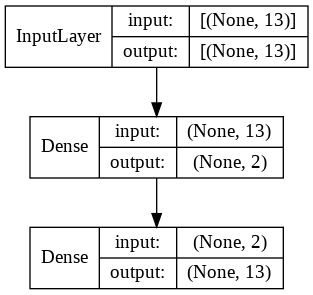

In [ ]:
model = models.Sequential()
# https://www.tensorflow.org/api_docs/python/tf/keras/activations   # network.add( layers.Dense(2, activation='relu', input_shape=(12,) ) )
model.add( layers.Dense(2, activation='linear', input_shape=(ONE_HOT_DIM,) ) )
model.add( layers.Dense(ONE_HOT_DIM, activation='softmax' ) )
model.compile( optimizer='rmsprop', 
                 loss = 'categorical_crossentropy', 
                 metrics = ['accuracy'] )
plot_model(model, show_shapes=1, show_dtype=0,show_layer_names=0)              # plot_model(model, show_shapes=1, show_layer_names=1)

In [ ]:
model.fit( X_train, Y_train, epochs=1, batch_size=1, verbose=1)
# d2 = pd.DataFrame(  model.weights[0].numpy(),  columns = ['x1', 'x2'] )
# w2v_df = pd.concat( [w2idx,d2],axis=1 )

42/42 [==============================] - 0s 907us/step - loss: 2.6373 - accuracy: 0.0409


In [ ]:
res=model.predict(X_train)
print(X_train.shape, res.shape)

(42, 13) (42, 13)


In [ ]:
res

array([[0.06913, 0.06313, 0.08585, 0.08248, 0.095  , 0.06771, 0.06682,
        0.1024 , 0.08284, 0.06962, 0.05849, 0.07756, 0.07899],
       [0.06913, 0.06313, 0.08585, 0.08248, 0.095  , 0.06771, 0.06682,
        0.1024 , 0.08284, 0.06962, 0.05849, 0.07756, 0.07899],
       [0.0752 , 0.07814, 0.06585, 0.07282, 0.0659 , 0.09056, 0.08923,
        0.05254, 0.07886, 0.07925, 0.10295, 0.07814, 0.07055],
       [0.0752 , 0.07814, 0.06585, 0.07282, 0.0659 , 0.09056, 0.08923,
        0.05254, 0.07886, 0.07925, 0.10295, 0.07814, 0.07055],
       [0.07212, 0.06766, 0.08286, 0.08077, 0.08844, 0.07081, 0.07047,
        0.09275, 0.08138, 0.07259, 0.06428, 0.0776 , 0.07827],
       [0.07212, 0.06766, 0.08286, 0.08077, 0.08844, 0.07081, 0.07047,
        0.09275, 0.08138, 0.07259, 0.06428, 0.0776 , 0.07827],
       [0.06043, 0.05576, 0.07588, 0.08323, 0.09413, 0.08389, 0.07715,
        0.07407, 0.09316, 0.06625, 0.079  , 0.08315, 0.0739 ],
       [0.06043, 0.05576, 0.07588, 0.08323, 0.09413, 0.08389, 

In [ ]:
Y_train

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 

In [ ]:
w2v_df
# w2idx

,values,word,x1,x2
0,0,балерина,4.0,2.4
1,1,вдохновляет,-0.0,0.9
2,2,девочку,0.4,1.9
3,3,женщина,0.1,1.0
4,4,кичлам,-1.3,-2.1
5,5,красивая,0.5,0.8
6,6,ловкий,2.4,-4.4
7,7,молодой,-1.3,-2.7
8,8,мужчина,2.4,-5.4
9,9,сильный,-1.8,-3.0


In [ ]:
# https://towardsdatascience.com/advanced-keras-constructing-complex-custom-losses-and-metrics-c07ca130a618



# # Build a model
# inputs = Input(shape=(128,))
# layer1 = Dense(64, activation='relu')(inputs)
# layer2 = Dense(64, activation='relu')(layer1)
# predictions = Dense(10, activation='softmax')(layer2)
# model = Model(inputs=inputs, outputs=predictions)

# # Define custom loss
# def custom_loss(layer):

#     # Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer
#     def loss(y_true,y_pred):
#         return K.mean(K.square(y_pred - y_true) + K.square(layer), axis=-1)
   
#     # Return a function
#     return loss
    
# # Compile the model
# model.compile(optimizer='adam',
#               loss=custom_loss(layer), # Call the loss function with the selected layer
#               metrics=['accuracy'])

# # train
# model.fit(data, labels)  